<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [45]:
import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import ttest_ind  

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

- UserID: Numero único que identifica a cada jugador.
- Version: Si el jugador se colocó en el grupo de control (puerta_30 - una puerta en el nivel 30) o en el grupo con la puerta movida (puerta_40 - una puerta en el nivel 40).
- sum_gamerounds: El número de rondas de juego jugadas por el jugador durante los primeros 14 días después de la instalación.
- retention_1: ¿Regresó el jugador y jugó 1 día después de la instalación?
- retention_7: ¿Regresó el jugador y jugó 7 días después de la instalación?


- Los datos estan alojados en data/cookie_cats.csv. 
- Nuestro grupo de control sera la version actual gate_30 y el grupo de tratamiento sera la version gate_40. 
- Debemos realizar el test para 1 dia de retencion retention_1 y para 7 dias retention_7.

---

In [46]:
# ttest de 2 colas
# bayes al principio xq no tengo muestra, 
# llegara un momento q tenga q decidir, formalismo con bayes o datos al final de sobra, para hacerlo frecuentista
# dividir por gate 30 o 40, y luego comparar x los 1-1 y 7-7

In [47]:
# datos
cats_game = pd.read_csv('data/cookie_cats.csv')
cats_game.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [48]:
cats_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [49]:
cats_game.shape

(90189, 5)

In [50]:
cats_game['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [51]:
cats_game['retention_1'].value_counts()

retention_1
False    50036
True     40153
Name: count, dtype: int64

In [52]:
cats_game['retention_7'].value_counts()

retention_7
False    73408
True     16781
Name: count, dtype: int64

In [53]:
cats_game['sum_gamerounds'].value_counts()

sum_gamerounds
1       5538
2       4606
0       3994
3       3958
4       3629
        ... 
858        1
1102       1
618        1
1027       1
708        1
Name: count, Length: 942, dtype: int64

In [54]:
cats_game['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

<Axes: xlabel='retention_1,retention_7'>

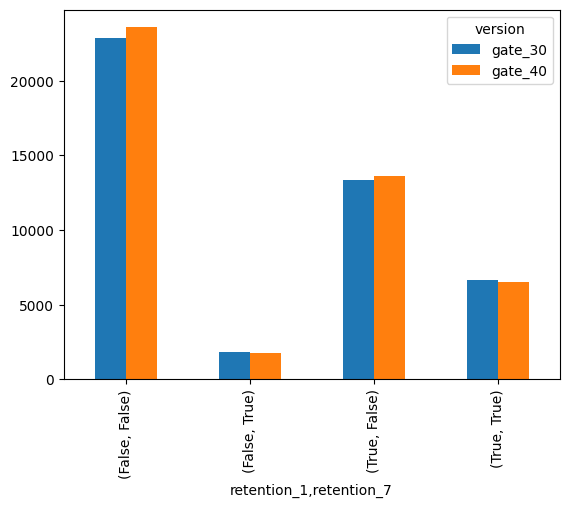

In [55]:
data_cross = cats_game.groupby(['retention_1', 'retention_7', 'version']).size().unstack()

data_cross.plot(kind='bar')

---

In [56]:
# transformacion



---

In [57]:
# muestreo
control = cats_game[cats_game.version == 'gate_30'].sample(n=4720, random_state=22) 
tratamiento = cats_game[cats_game.version == 'gate_40'].sample(n=4720, random_state=22)

ab_test = pd.concat([control, tratamiento], axis=0) #lista de dataframes

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [58]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
9435,8267302,gate_40,27,False,False
9436,7145315,gate_40,113,True,True
9437,396129,gate_40,20,True,False
9438,2165928,gate_40,0,False,False
9439,2888784,gate_40,5,False,False


In [59]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          9440 non-null   int64 
 1   version         9440 non-null   object
 2   sum_gamerounds  9440 non-null   int64 
 3   retention_1     9440 non-null   bool  
 4   retention_7     9440 non-null   bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 239.8+ KB


In [60]:
ab_test.version.value_counts()

version
gate_30    4720
gate_40    4720
Name: count, dtype: int64

---

In [64]:
# testeo para retention_1
control_res1 = ab_test[ab_test.version=='gate_30']['retention_1']
control_res1


0        True
1        True
2        True
3       False
4        True
        ...  
4715    False
4716    False
4717    False
4718     True
4719    False
Name: retention_1, Length: 4720, dtype: bool

In [62]:
# testeo para retention_1
control_res2 = ab_test[ab_test.version=='gate_40']['retention_1']
control_res2

4720    False
4721    False
4722    False
4723    False
4724     True
        ...  
9435    False
9436     True
9437     True
9438    False
9439    False
Name: retention_1, Length: 4720, dtype: bool

In [63]:
# testeo para retention_1

tasas_conversion = cats_game.groupby('version')['retention_1']

tasas_conversion = tasas_conversion.agg([np.mean,
                                         lambda x: np.std(x, ddof=0), # std con 0 grados de libertad
                                         lambda x: stats.sem(x, ddof=0)]) # error medio? el resultado de sem=0.005 significa error medio del 0,005%

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')


C:\Users\blanx\AppData\Local\Temp\ipykernel_7788\1551686603.py:5: FutureWarning: The provided callable <function mean at 0x00000242CCB62700> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tasas_conversion = tasas_conversion.agg([np.mean,


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

---

In [ ]:
# testeo para retention_7
trat_res1 = ab_test[ab_test.version=='gate_30']['retention_7']
trat_res1

0       False
1       False
2       False
3       False
4        True
        ...  
4715    False
4716    False
4717    False
4718     True
4719    False
Name: retention_7, Length: 4720, dtype: bool

In [ ]:
# testeo para retention_7
trat_res2 = ab_test[ab_test.version=='gate_40']['retention_7']
trat_res2

4720    False
4721    False
4722    False
4723    False
4724     True
        ...  
9435    False
9436     True
9437    False
9438    False
9439    False
Name: retention_7, Length: 4720, dtype: bool

In [65]:
sum(control_res1), sum(trat_res1)

(2102, 836)

In [66]:
sum(control_res2), sum(trat_res2)

(2046, 836)

In [ ]:
# testeo para retention_7

tasas_conversion = cats_game.groupby('version')['retention_7']

tasas_conversion = tasas_conversion.agg([np.mean,
                                         lambda x: np.std(x, ddof=0), # std con 0 grados de libertad
                                         lambda x: stats.sem(x, ddof=0)]) # error medio? el resultado de sem=0.005 significa error medio del 0,005%

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')


C:\Users\blanx\AppData\Local\Temp\ipykernel_7788\388764577.py:5: FutureWarning: The provided callable <function mean at 0x00000242CCB62700> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tasas_conversion = tasas_conversion.agg([np.mean,


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [71]:
impresiones = [control_res1.shape[0], trat_res1.shape[0]]   # entrar en al pagina 

conversiones = [sum(control_res1), sum(trat_res1)]  # comprar en la pagina



z_score, p_value = proportions_ztest(conversiones, 
                                     nobs=impresiones)


(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, # calculamos los intervalos de confianza
                                                                nobs=impresiones, # numor de observaciones
                                                                alpha=0.05)

In [72]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

#p-valor: 0.732, es mayor q 0.05, no podemos rechazar la h0

z-score: 28.14
p-valor: 0.000
intervalo conf 95% para grupo control: [0.431, 0.460]
intervalo conf 95% para grupo tratamiento: [0.166, 0.188]


---

In [73]:
impresiones = [control_res2.shape[0], trat_res2.shape[0]]   # entrar en al pagina 

conversiones = [sum(control_res2), sum(trat_res2)]  # comprar en la pagina



z_score, p_value = proportions_ztest(conversiones, 
                                     nobs=impresiones)


(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, # calculamos los intervalos de confianza
                                                                nobs=impresiones, # numor de observaciones
                                                                alpha=0.05)

In [74]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

#p-valor: 0.732, es mayor q 0.05, no podemos rechazar la h0

z-score: 27.04
p-valor: 0.000
intervalo conf 95% para grupo control: [0.419, 0.448]
intervalo conf 95% para grupo tratamiento: [0.166, 0.188]


---

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['converted'])

plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

KeyError: 'converted'

<Figure size 800x600 with 0 Axes>

---

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

''' 
Dado que el $p$-valor=0.732 es mayor que $\alpha$=0.05, no podemos rechazar la hipótesis nula $H_0$, lo que significa que el nuevo diseño de la página no tiene un rendimiento significativamente diferente del viejo diseño.

Adicionalmente, si se observa el intervalo de confianza para el grupo de  `tratamiento`([0.116, 0.135], i.e. 11.6-13.5%) nos damos cuenta de que:
1. Incluye nuestro valor base del 13% en la tasa de conversion
2. No incluye nuestro valor objetivo del 15% (el 2% de subida que buscabamos)

Todo esto implica que lo más probable es que la tasa de conversión del nuevo diseño sea similar al viejo diseño de la web, y no llegaría a ese 15% buscado. Esto probaría que el diseño no mejora nuestra tasa de conversión y que habría que volver a la mesa de diseño.
'''